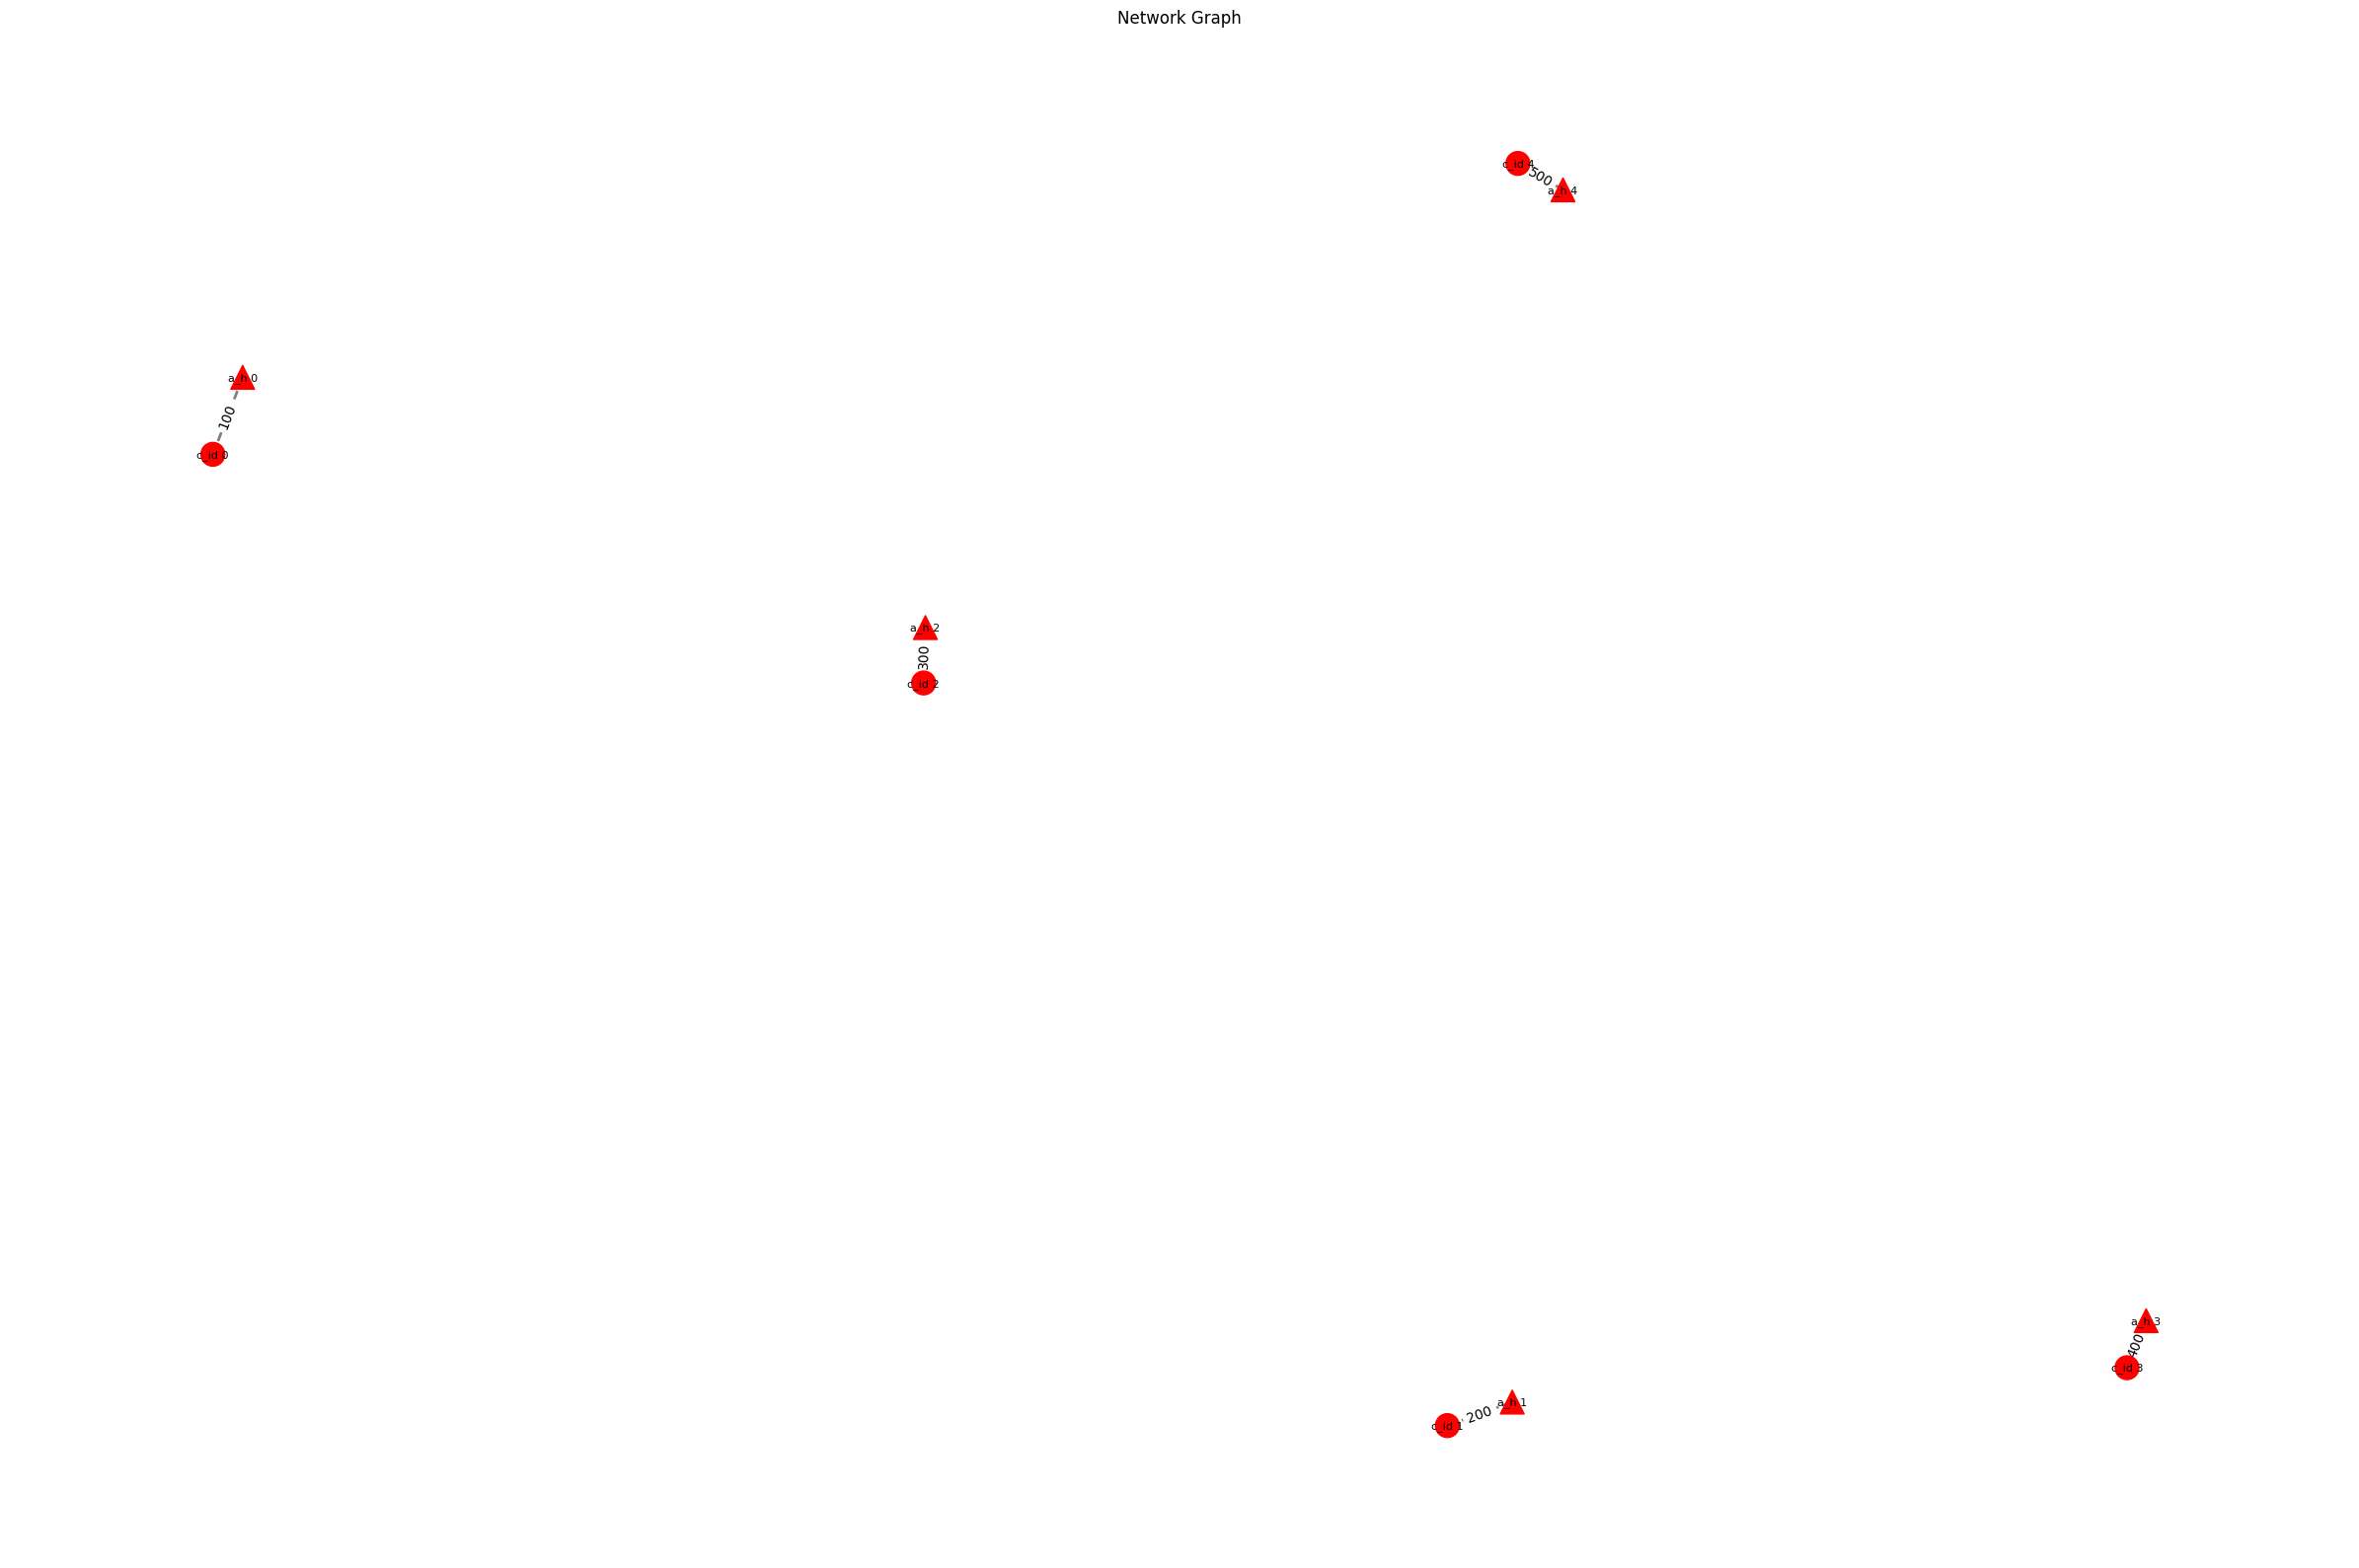

In [1]:
import pandas as pd
import warnings
from functions import *

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the data
df1 = read_excel('idtobank.xlsx')
df2 = read_excel('hashtoid.xlsx')
fraud_data = read_excel('fraud.xlsx', sheet_name='Detail data')

df1 = preprocess_dataframe(df1)
df2 = preprocess_dataframe(df2)

df = pd.concat([df1, df2], ignore_index=True)
fraud_ids = fraud_data['customer_id'].unique()
df['is_fraud'] = df['customer_id'].isin(fraud_ids).astype(object)


print(df['is_fraud'])

describe_dataframe(df)

0        True
1        True
2        True
3        True
4        True
        ...  
4058    False
4059    False
4060    False
4061    False
4062    False
Name: is_fraud, Length: 4063, dtype: object
Number of rows: 4063
Number of columns: 57

Column names and data types:
success_redirect_url               object
account_details                    object
expires_at                         object
client                             object
fee                                object
refunded_amount                    object
payment_channel_transaction_id     object
linked_account_id                  object
is_otp_required                    object
otp_mobile_number                  object
settlement_date                    object
failure_code                       object
callback_url                       object
status                             object
channel_account_reference          object
updated                            object
version                            object
checkout_url   

In [3]:
# Dictionary for token mapping
token_mapping = {
    'account_hash': 'a_h ',
    'customer_id': 'c_id ',
    'email': 'e'
}

# Factorize and map columns
df, factorized_to_original, token_to_original = factorize_and_map(df, token_mapping)


# Example: Get original value from token-mapped value
get_original_value_from_token('a_h 0', token_to_original)

'b15dee28891e6e8b2061540556bd8e6711e3a14d2c755ea4b19ce0a9ffe48c79'

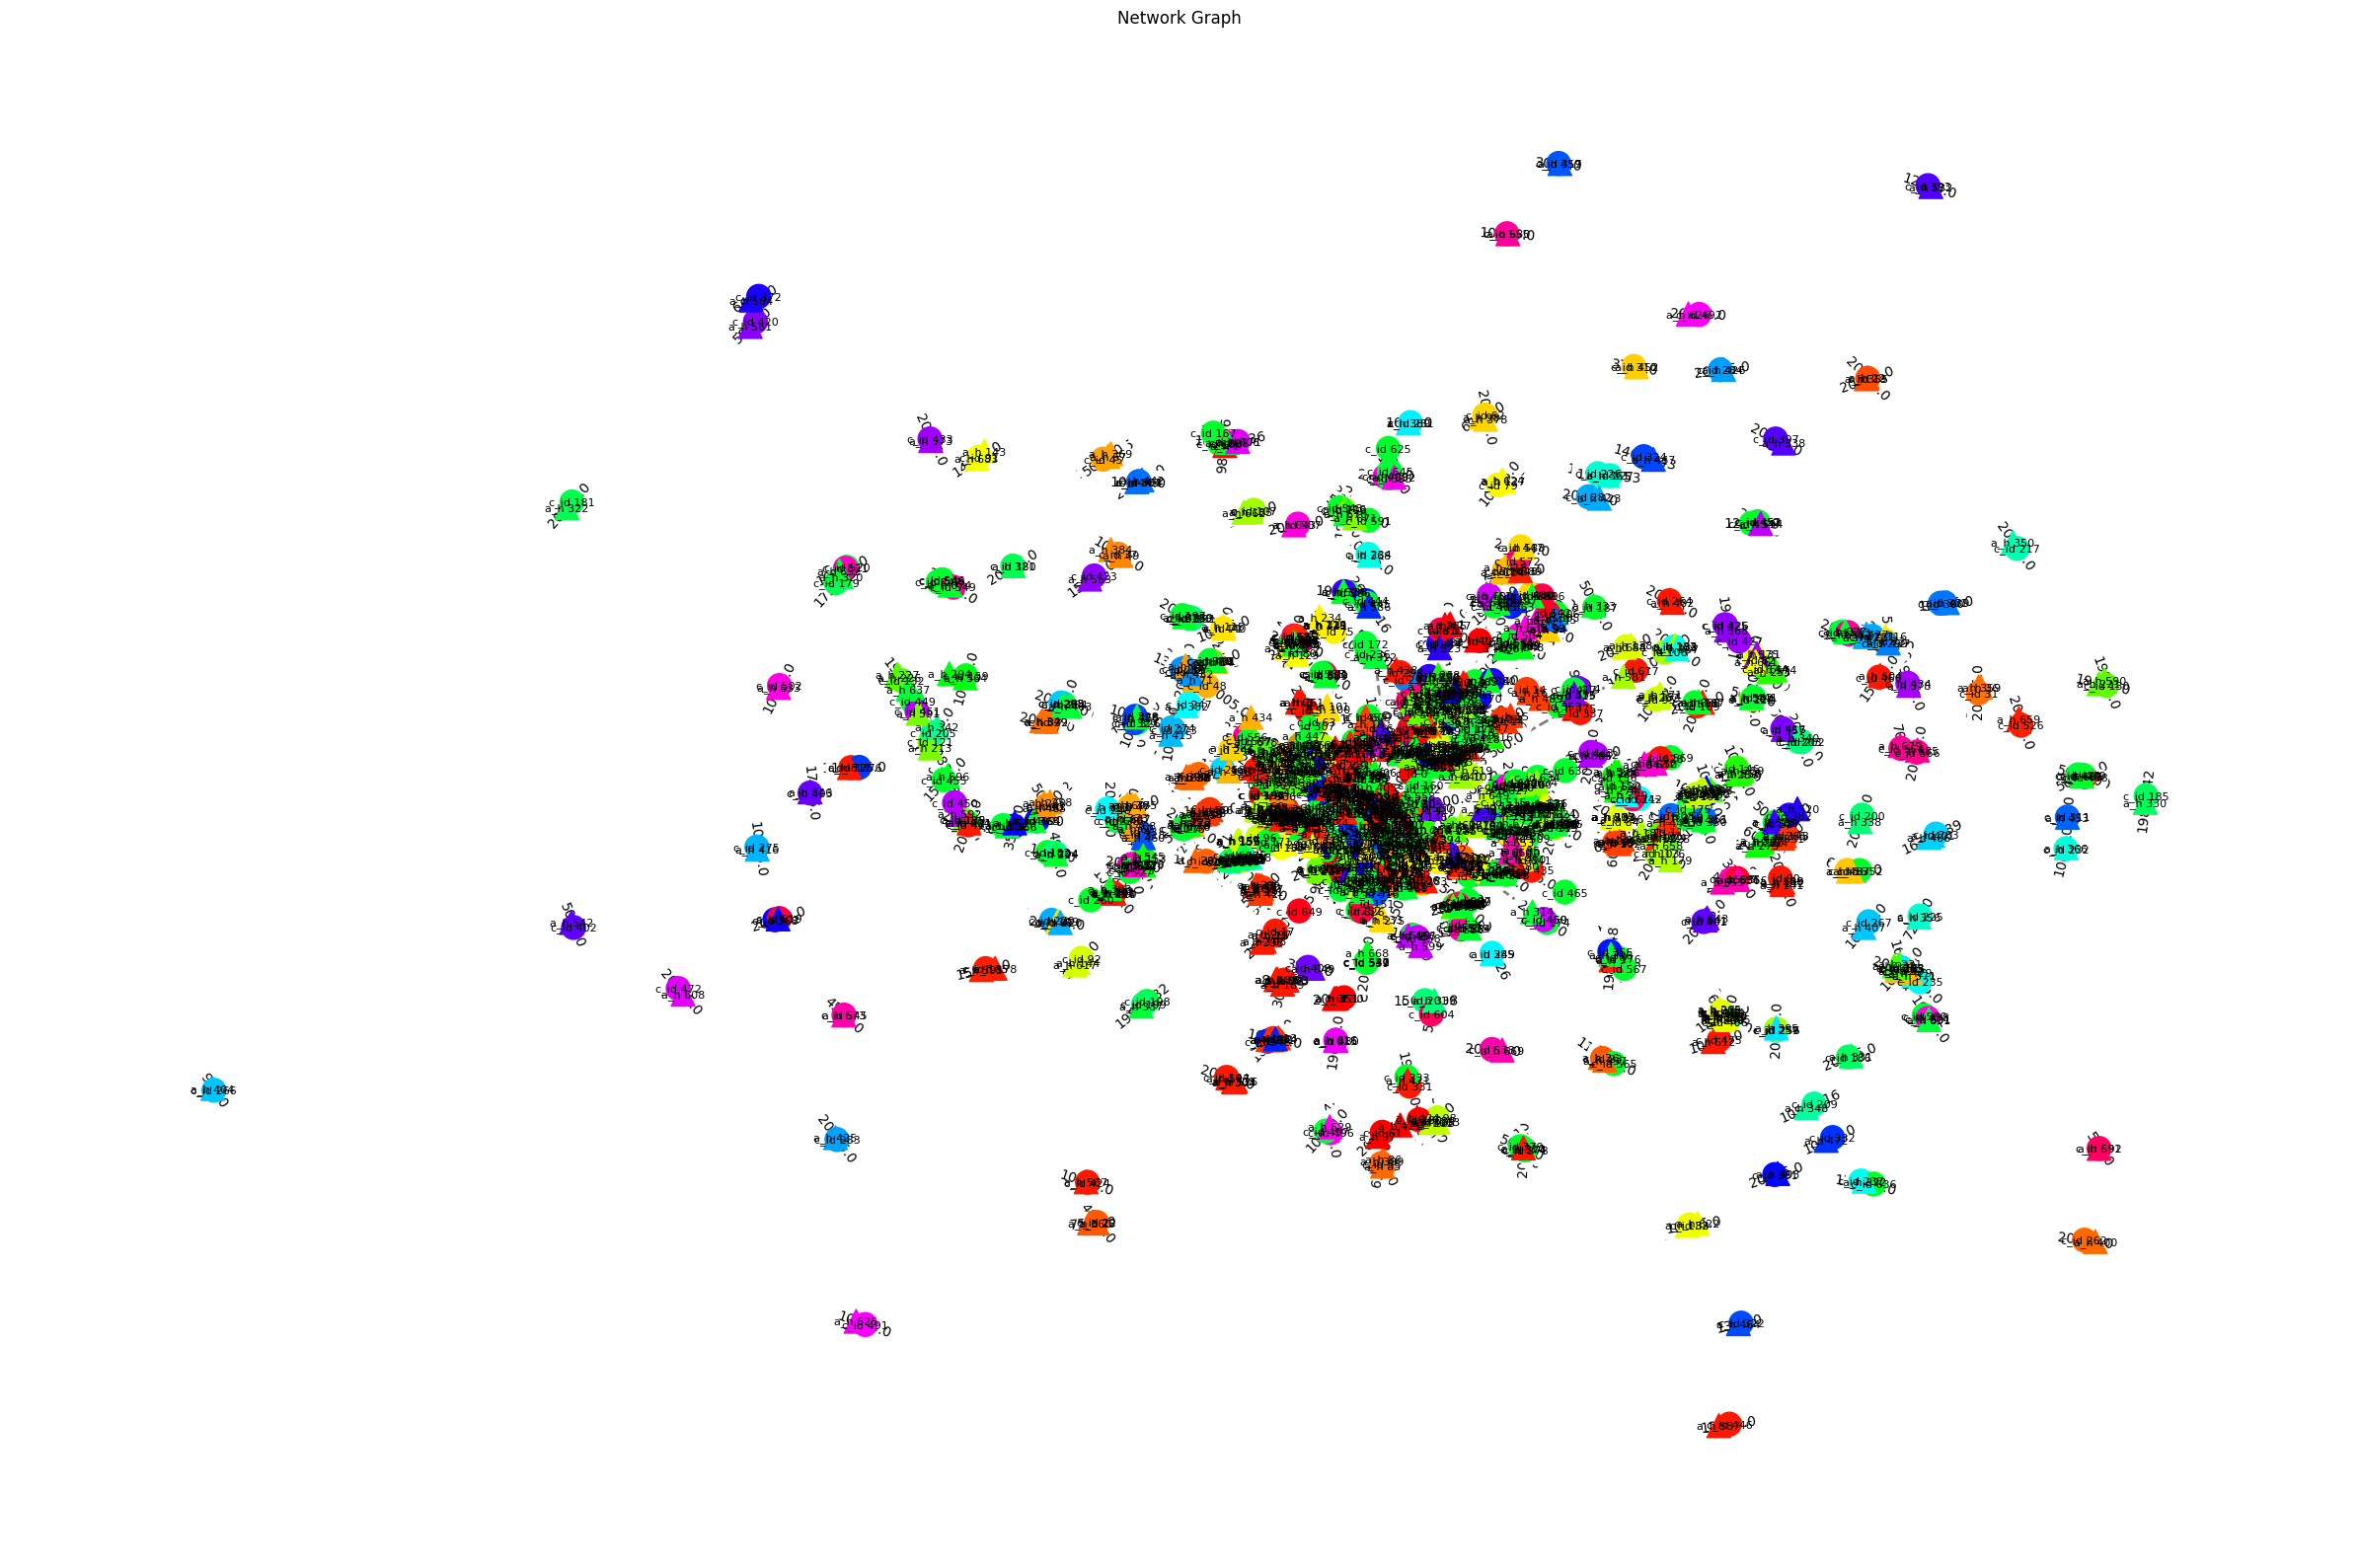

In [4]:
# Initialize the network graph
nodes = ['account_hash', 'customer_id']
node_attributes = ['is_fraud', 'email','surname']
edges = ['amount']

G = create_and_plot_network(df, nodes, edges, 'email',node_attributes)

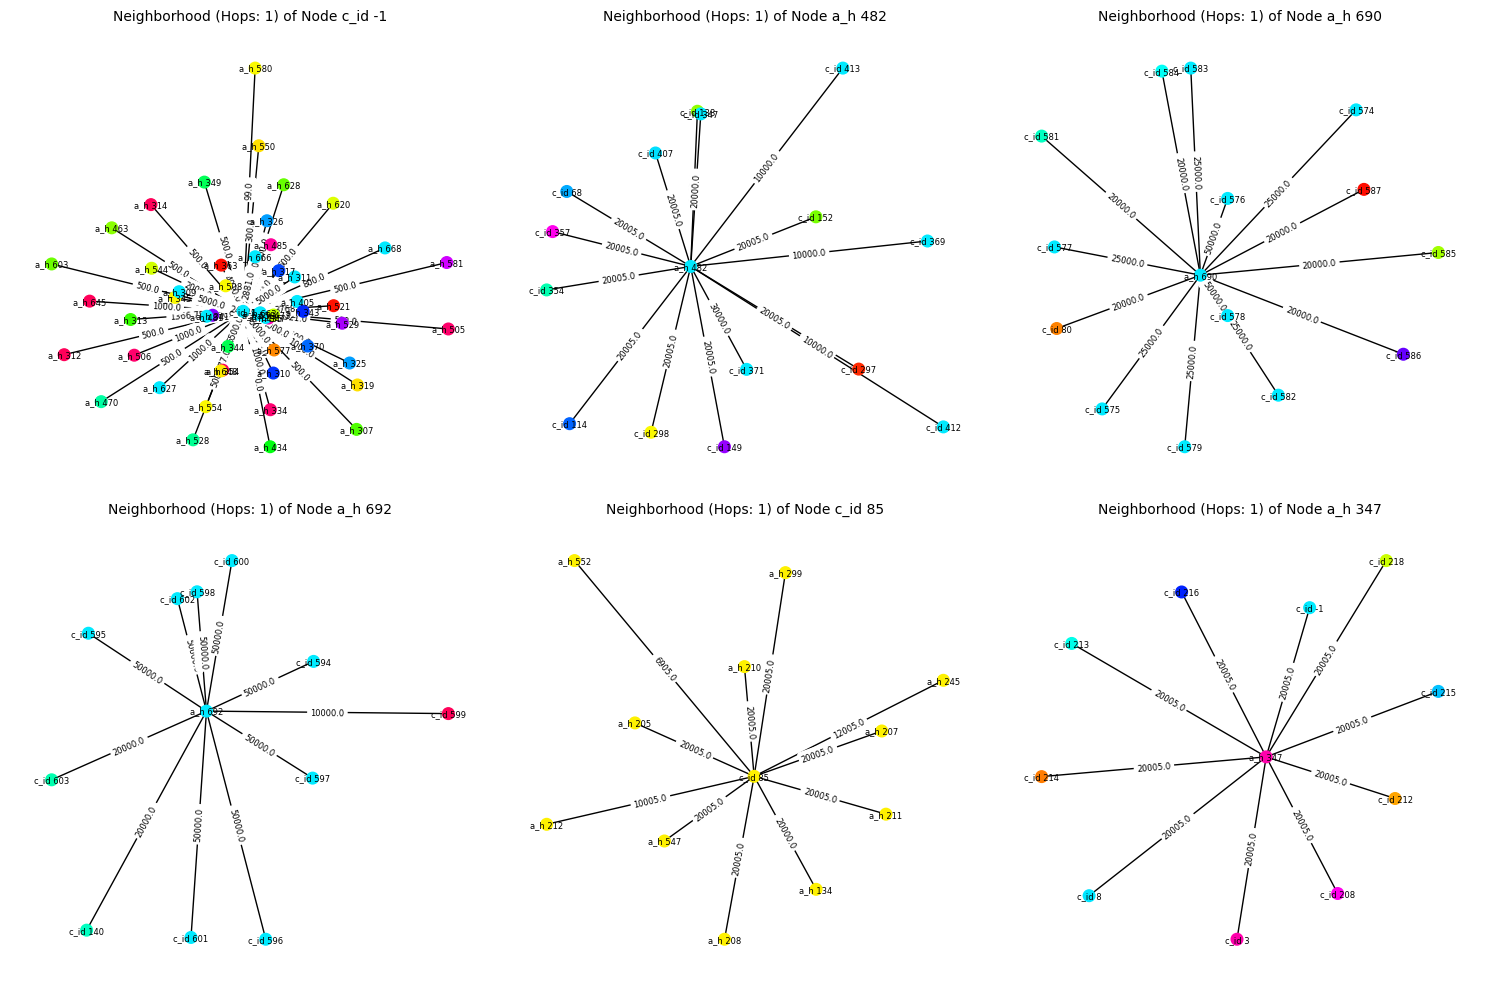

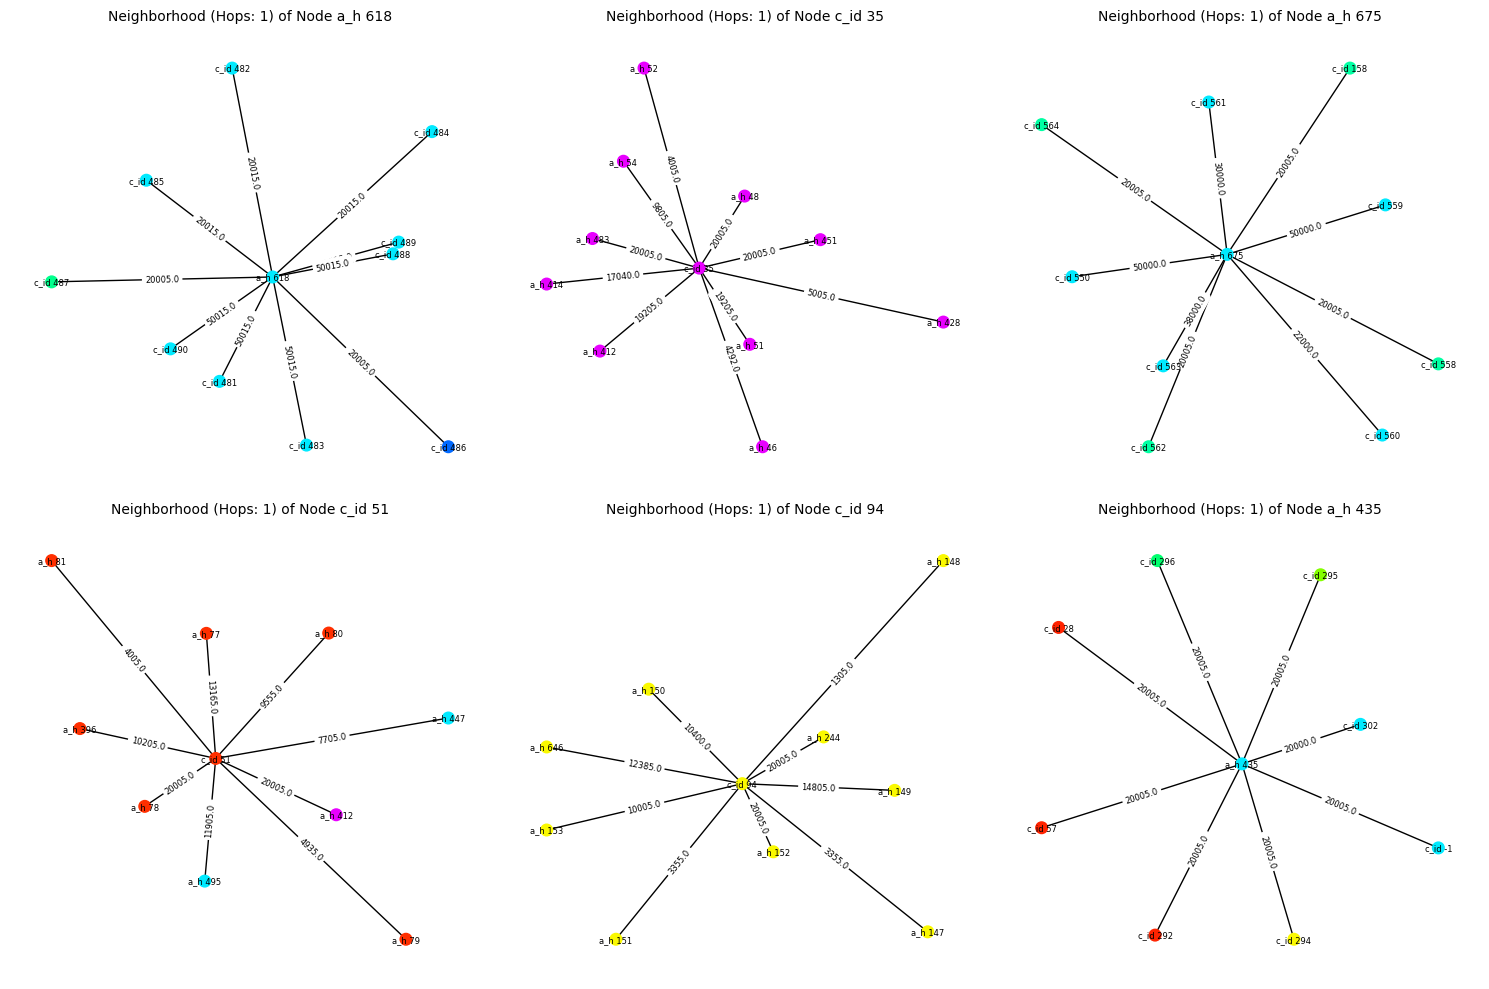

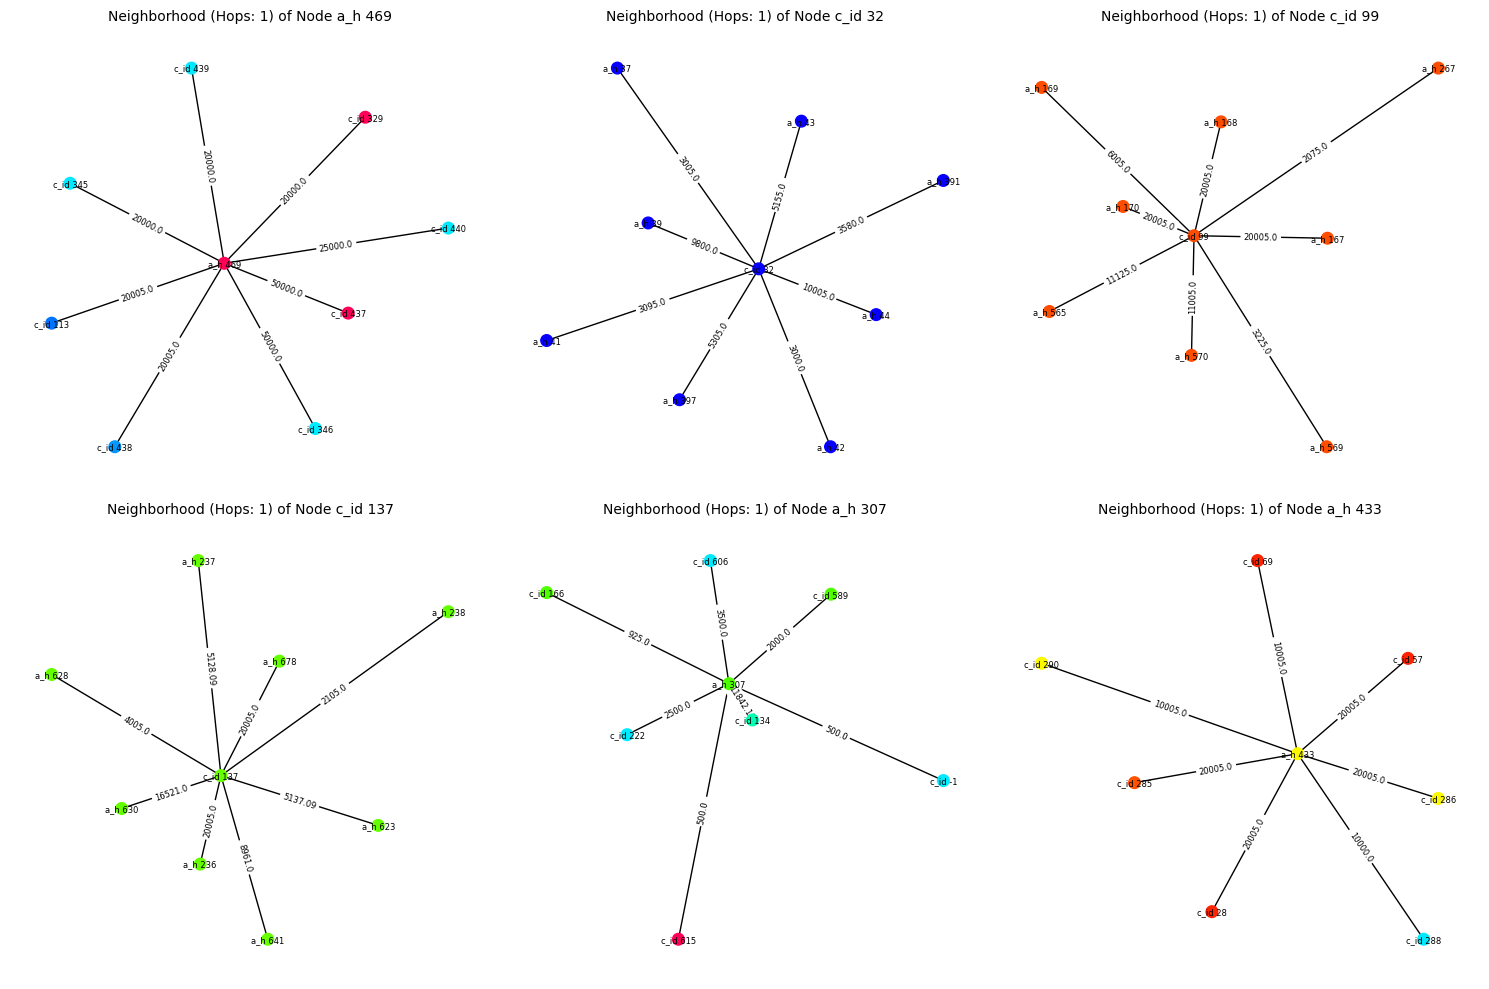

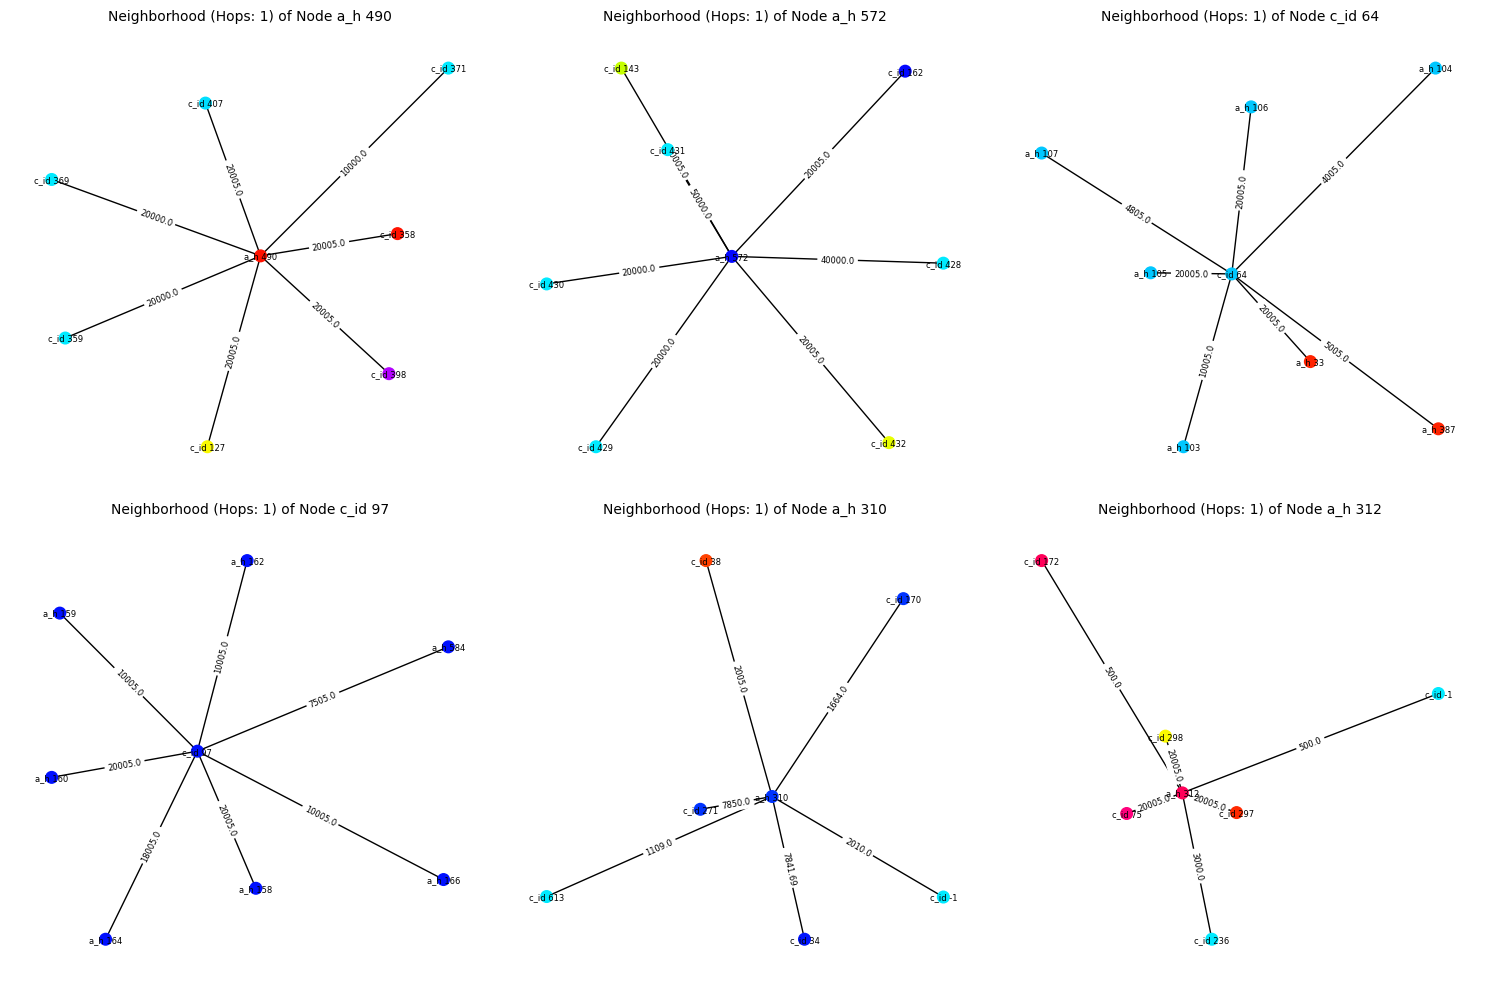

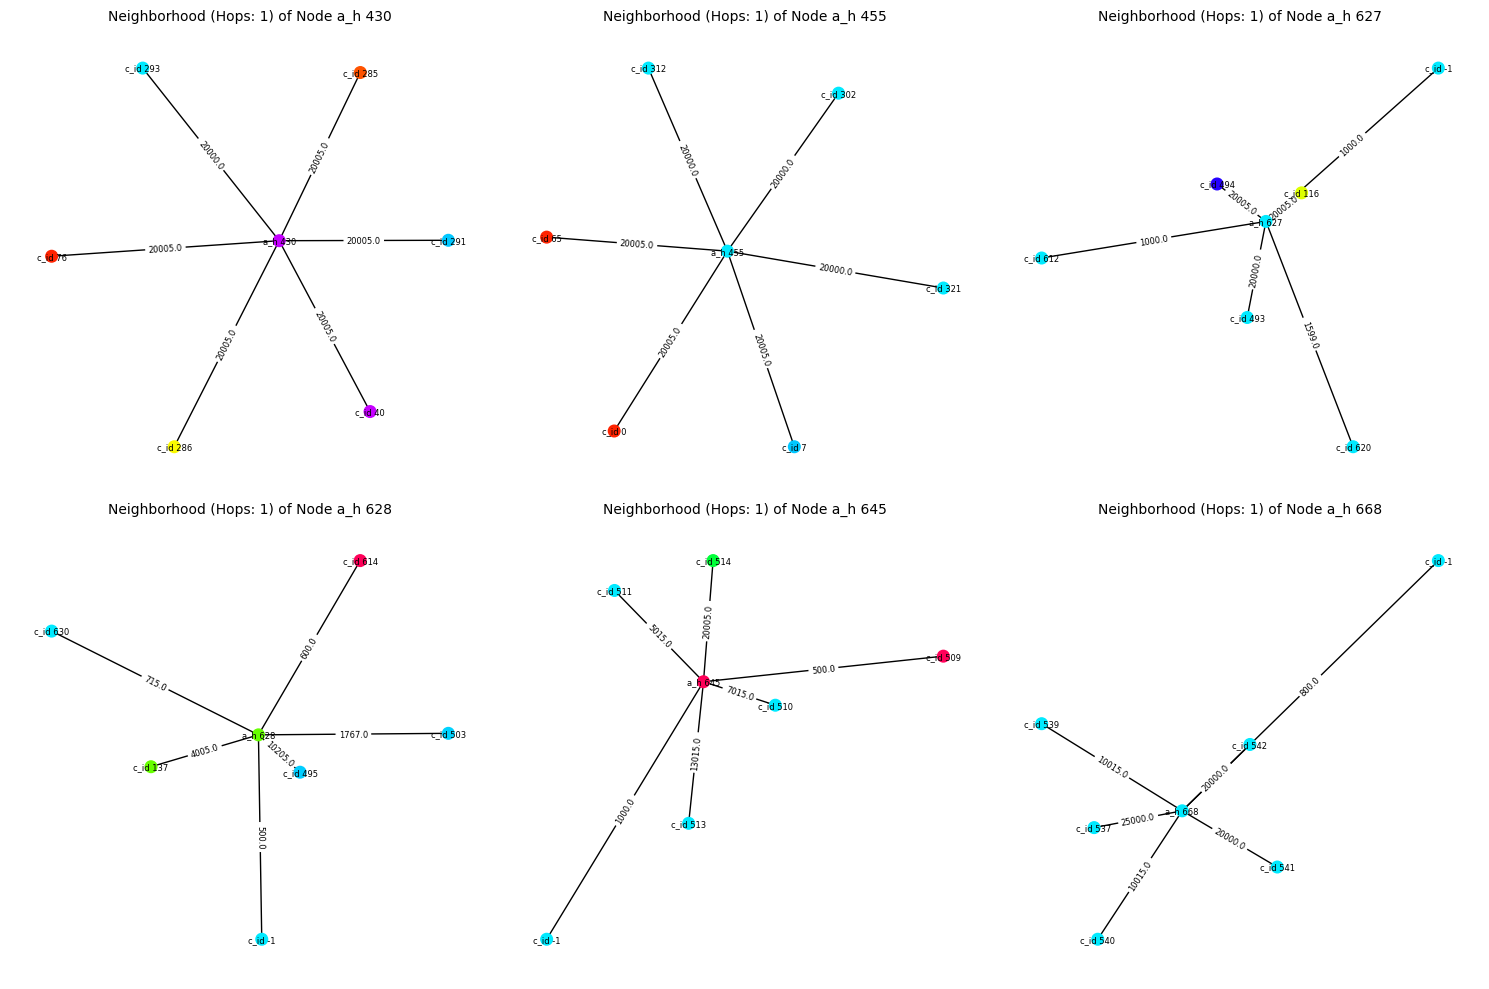

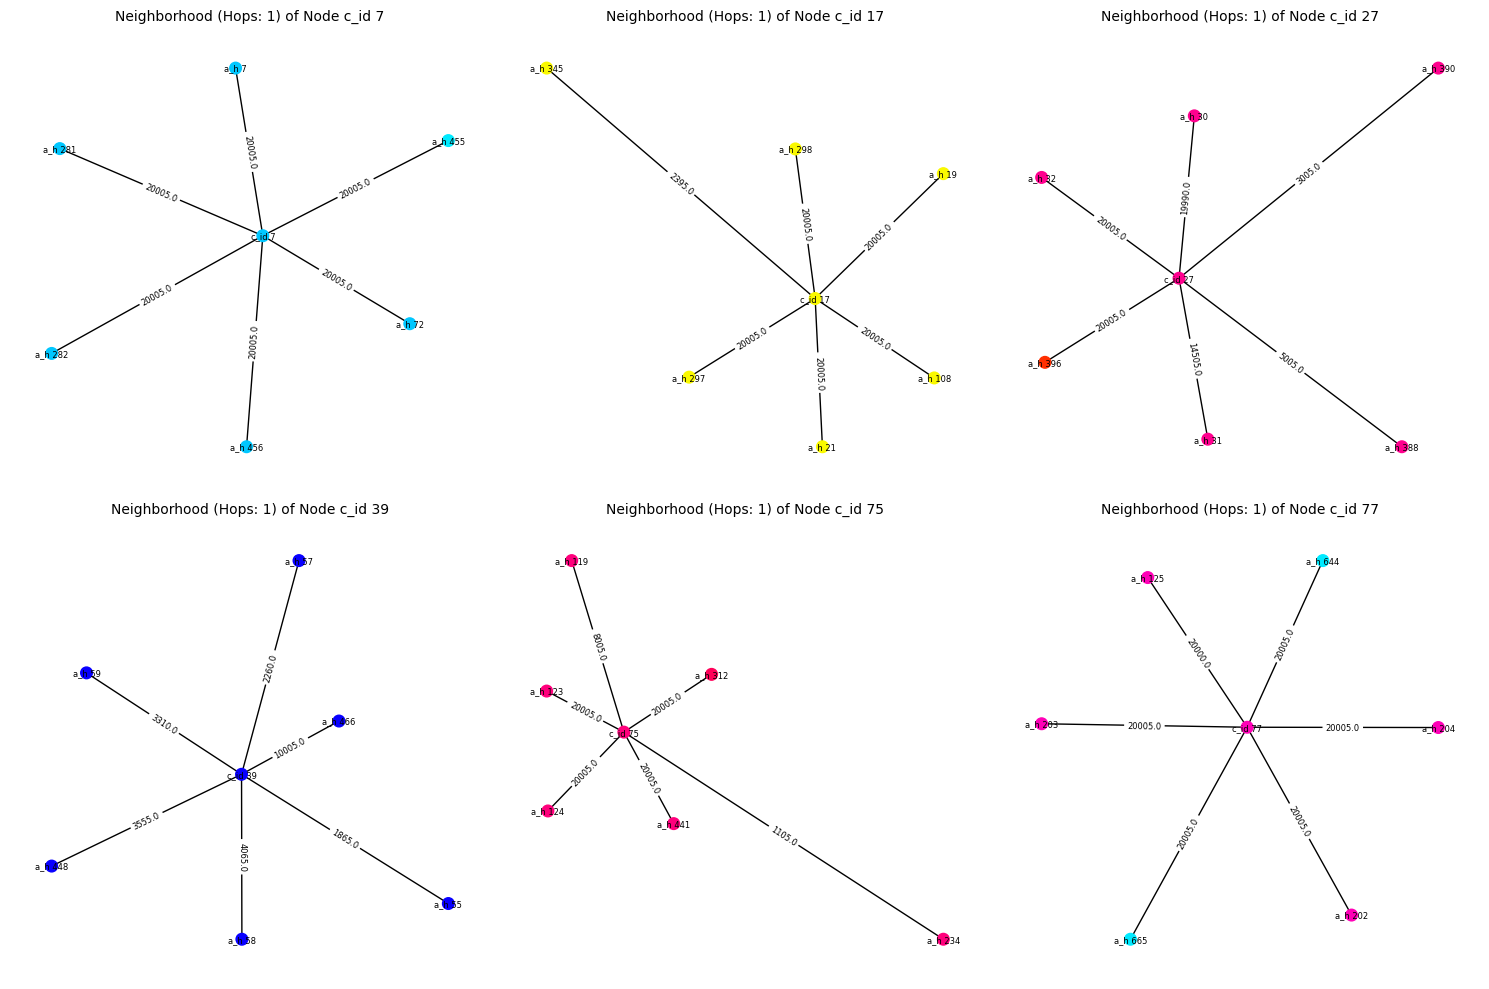

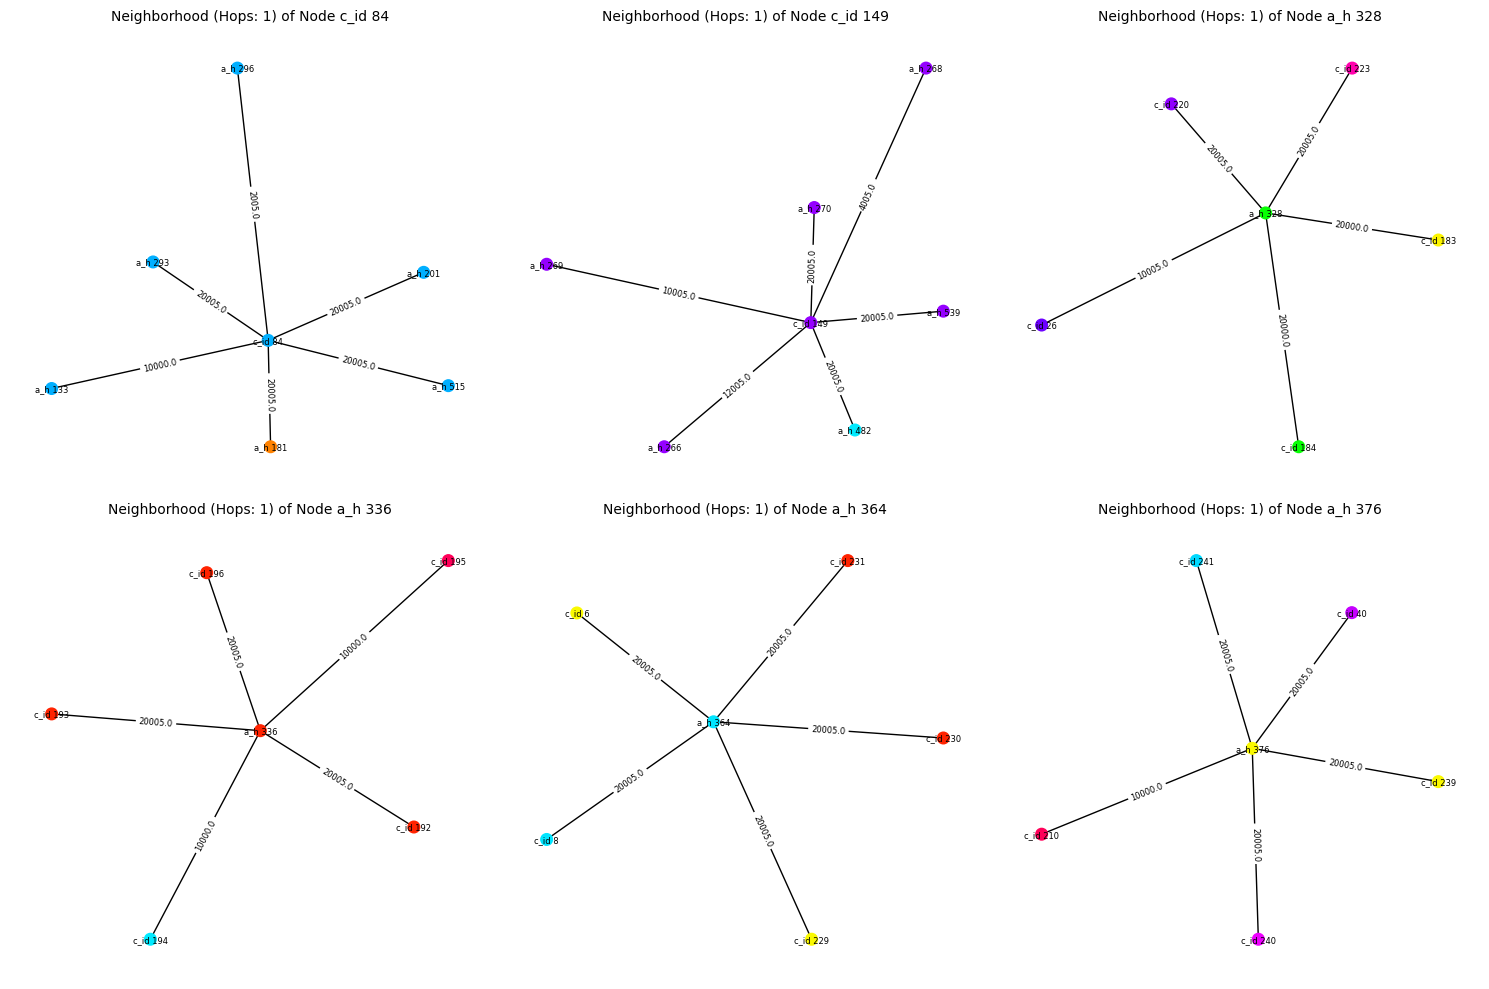

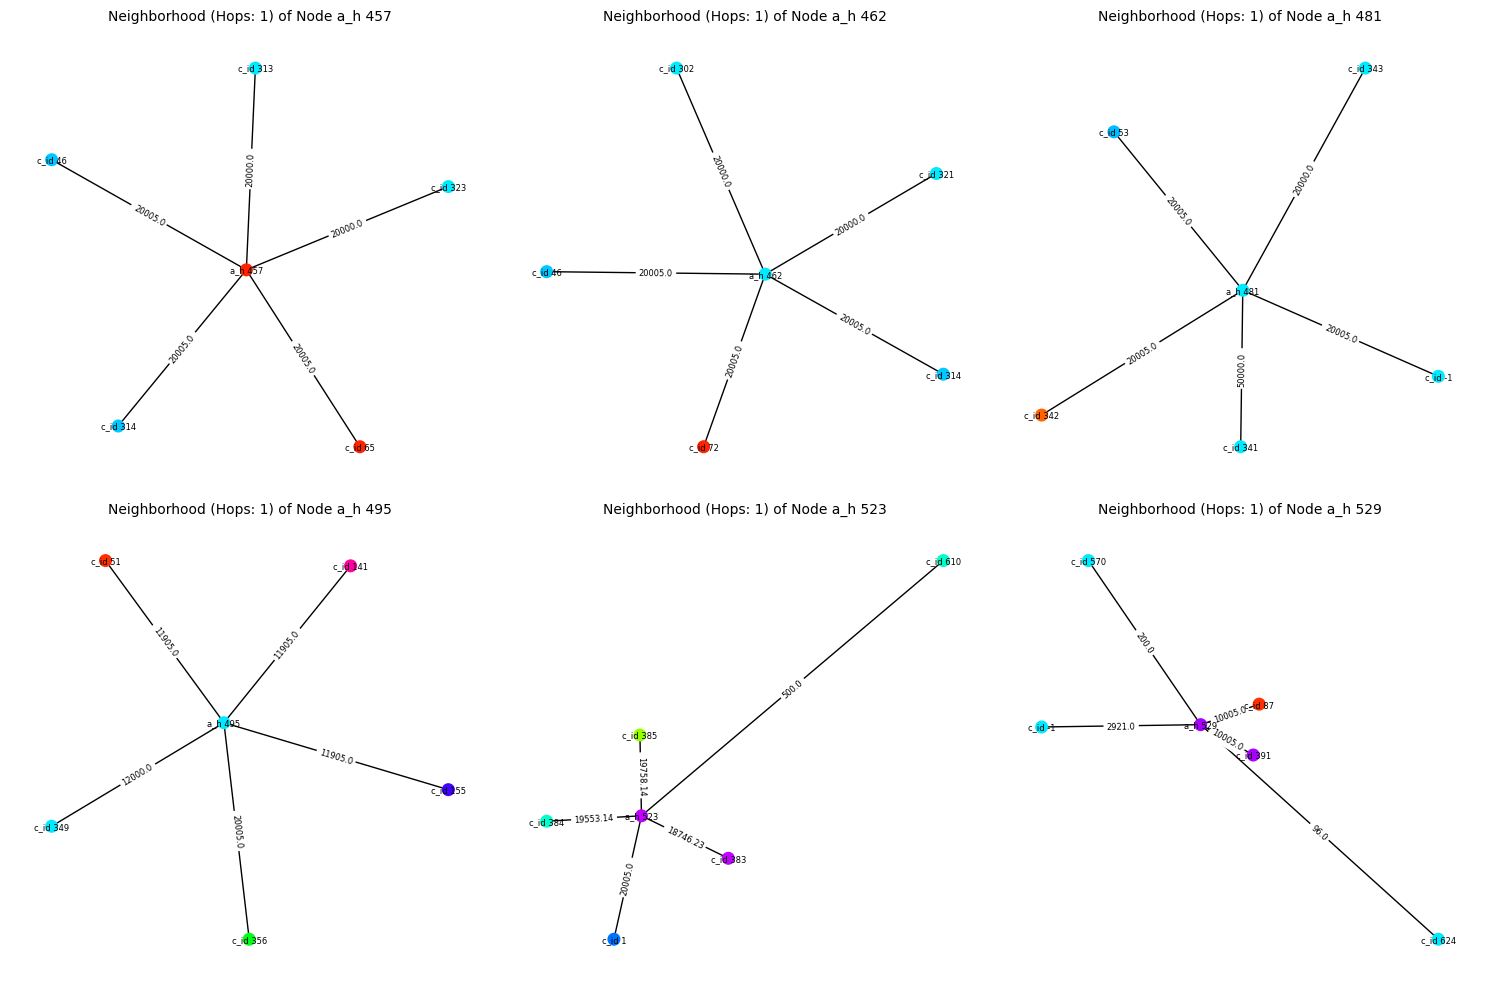

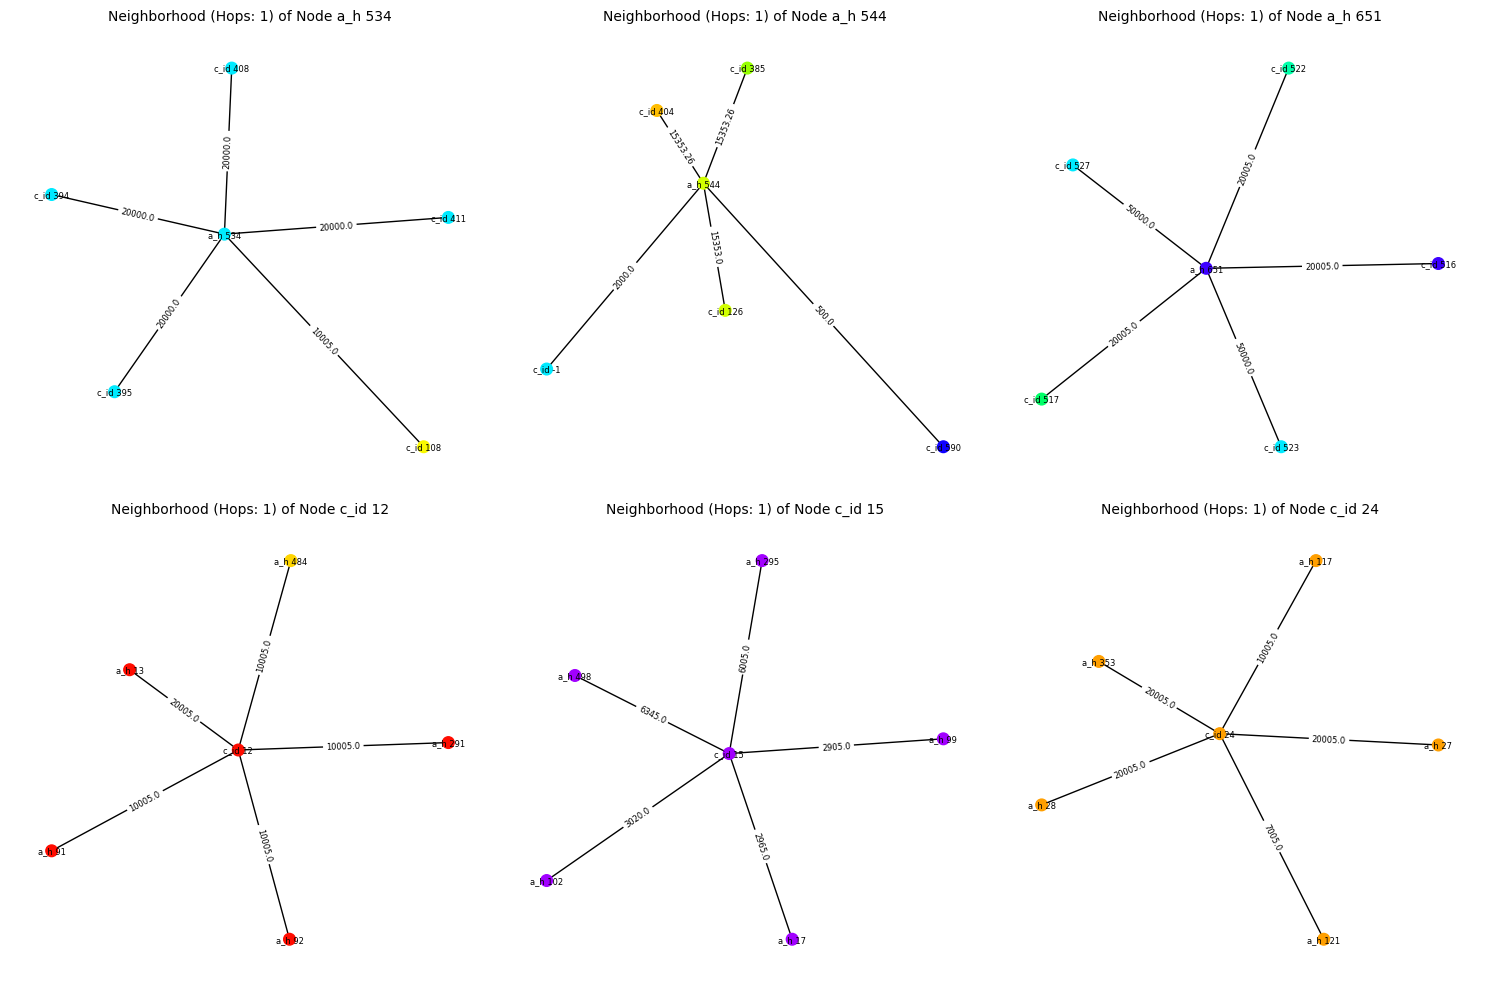

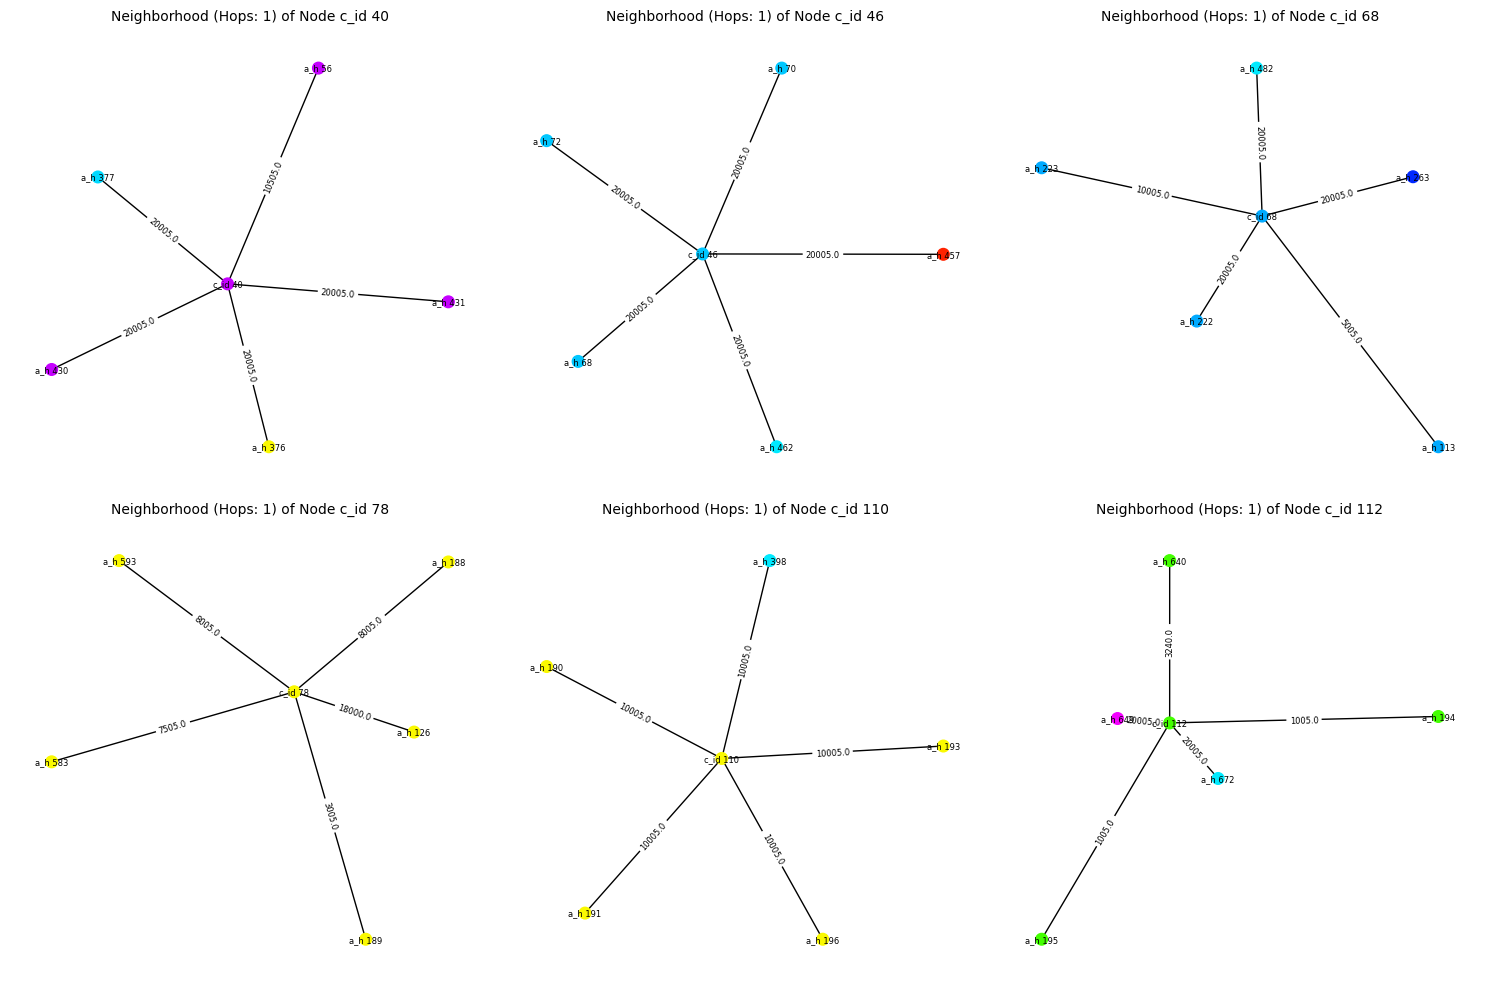

In [6]:
plot_subgraphs(G,num_hops=1)